# Red Neuronal Convolucional

In [1]:
# Importamos paquetes
# Cargamos paquetes necesarios

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pandas as pd
from PIL import Image

#helper was developed by Udacity under MIT license
# import helper

In [2]:
# Hiper-parámetros
batch_size = 64

Para este ejemplo usaremos el conjunto de datos [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Fashion-MNIST es un conjunto de datos desarrollado por Zalado que contiene imagenes de ropa asociadas con 10 clases. El conjunto contiene 60,000 ejemplos de entrenamiento y 10,000 para validación. Cada imagen tiene una resolución de 28x28 en un solo canal. Este conjunto comparte la misma estructura y tamaño con el conjunto de datos de MNIST.

A continuación crearemos los objetos Dataset y Dataloader que se encargarán del manejo del conjunto. Además mostraremos algunas estadísticas y ejemplos en el conjunto.

[2] Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms. arXiv preprint arXiv:1708.07747.

In [3]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, has_labels=True):
        """
        Dataset personalizado que lee imágenes desde un CSV con etiquetas como strings.
        Args:
            csv_file (str): Ruta al archivo CSV.
            image_dir (str): Carpeta donde se encuentran las imágenes.
            transform (callable, optional): Transformaciones a aplicar a las imágenes.
            has_labels (bool): Si el CSV contiene etiquetas o no.
        """
        self.data = pd.read_csv(csv_file)  # Carga del CSV
        self.image_dir = image_dir        # Carpeta con las imágenes
        self.transform = transform
        self.has_labels = has_labels      # Indicador si hay etiquetas en el CSV

        if has_labels:
            # Si tiene etiquetas, las extraemos
            self.image_paths = self.data.iloc[:, 0].values  # Primera columna: nombres de imágenes
            self.labels = self.data.iloc[:, 1].values       # Segunda columna: clases (strings)

            # Crear un mapeo de etiquetas string a índices numéricos
            self.class_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}
            self.idx_to_class = {idx: label for label, idx in self.class_to_idx.items()}  # Opcional, para decodificar

            # Convertir las etiquetas a índices
            self.labels = [self.class_to_idx[label] for label in self.labels]
        else:
            # Si no tiene etiquetas, solo extraemos las rutas
            self.image_paths = self.data.iloc[:, 0].values
            self.labels = None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Obtenemos la ruta de la imagen
        img_name = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_name).convert("RGB")  # Cargamos la imagen en formato RGB

        # Obtenemos la etiqueta si está disponible
        label = self.labels[idx] if self.has_labels else None

        # Aplicamos transformaciones si se especificaron
        if self.transform:
            image = self.transform(image)

        # Retornamos la imagen y la etiqueta (o solo la imagen si no hay etiquetas)
        return (image, label) if self.has_labels else image

In [4]:
# Definimos una transformación de los datos
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(), # convertir a tensores
                                transforms.Normalize([0.5], [0.5])]) #normalizar a media y desv std

# Rutas de los conjuntos de entrenamiento y prueba
train_dir = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\\clasifica-el-sargazo-24-b\\train_data.csv'
test_dir = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\\clasifica-el-sargazo-24-b\\test_data.csv'
img_dir = "C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\\clasifica-el-sargazo-24-b\\images_public"

# Descargamos el conjunto de entrenamiento y cargamos mediante un dataLoader
trainset = CustomDatasetFromCSV(train_dir, img_dir, transform=transform, has_labels=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

# Descargamos el conjunto de validación
testset = CustomDatasetFromCSV(test_dir, img_dir, transform=transform, has_labels=False)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

# Imprimir información estadística del conjunto de datos
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

# Verificación del mapeo de etiquetas
print("Mapeo de etiquetas a índices:", trainset.class_to_idx)

Train data, number of images:  2445
Test data, number of images:  272
Mapeo de etiquetas a índices: {'bajo': 0, 'abundante': 1, 'nada': 2, 'excesivo': 3, 'moderado': 4}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67058825..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49019605..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.99

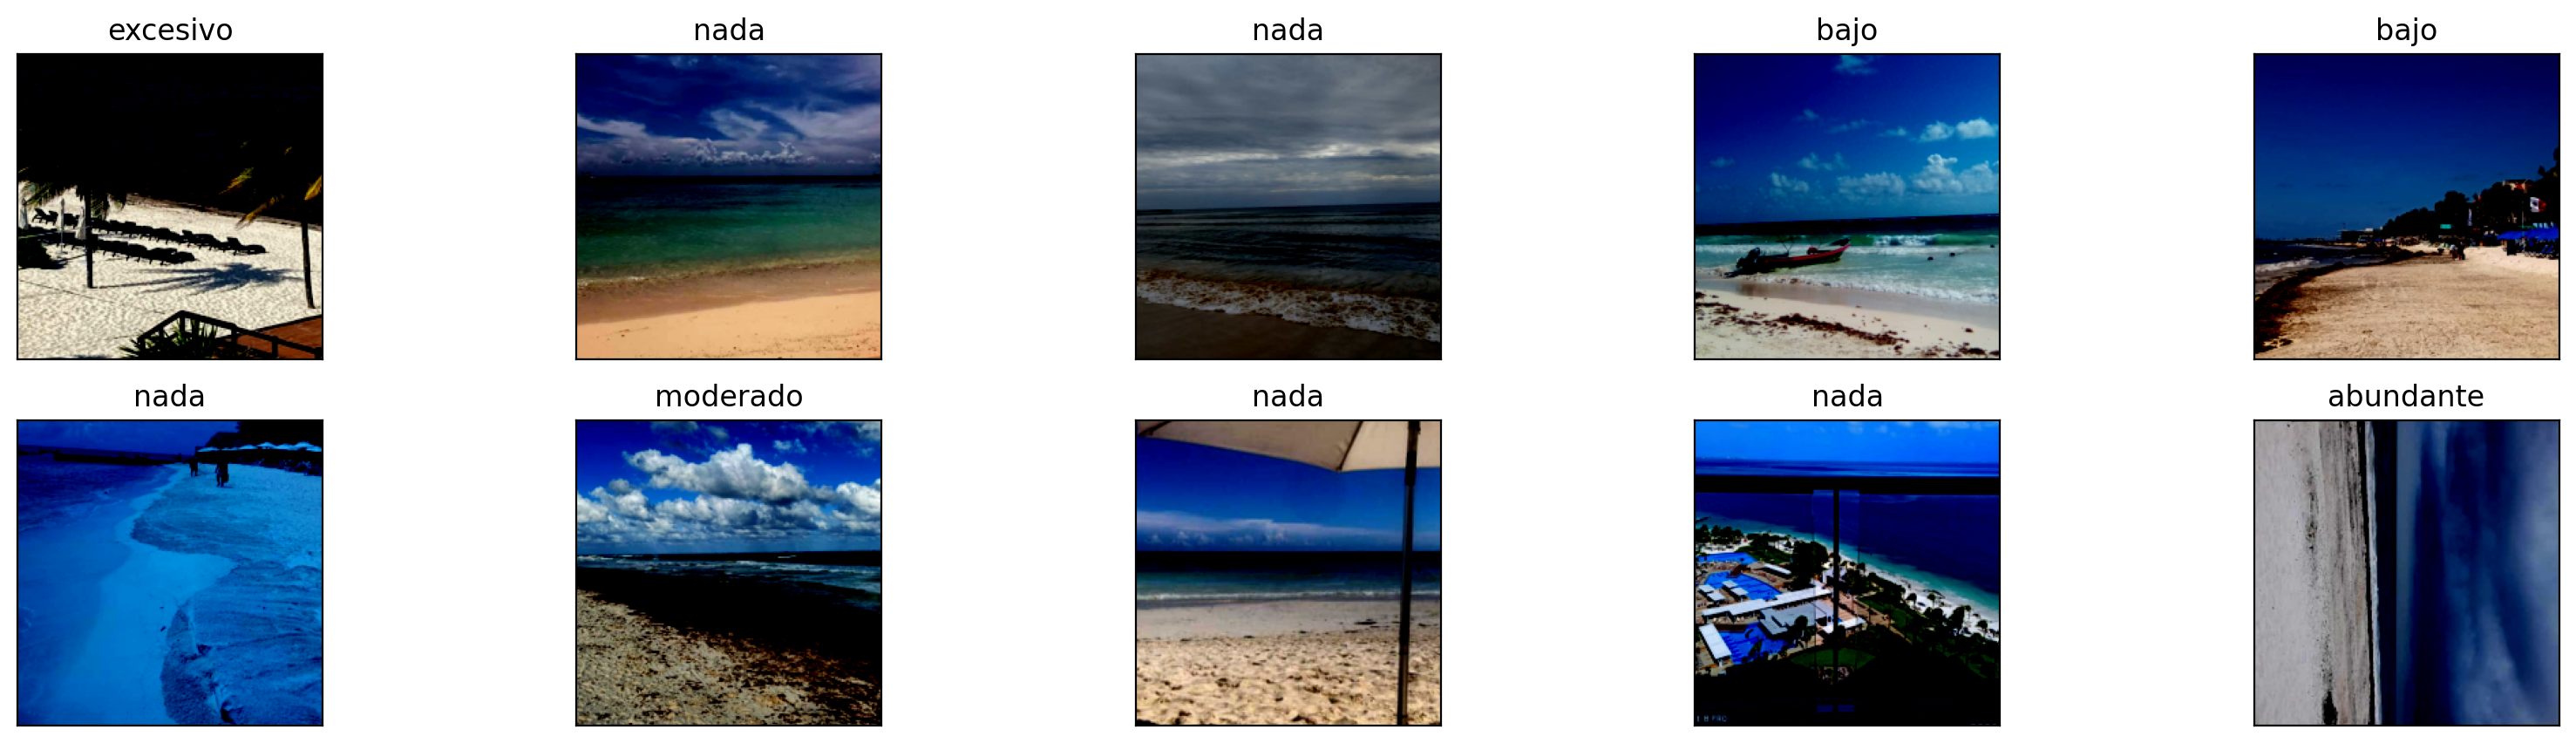

In [5]:
# # Obtener un lote de ejemplos
# dataiter = iter(trainloader)
# images, labels = next(dataiter)
# images = images.numpy()

# display_size = 10
# fig = plt.figure(figsize=(20, 5))

# for idx in np.arange(display_size):
#     ax = fig.add_subplot(2, display_size // 2, idx + 1, xticks=[], yticks=[])
#     # Convertir de tensor (C, H, W) a (H, W, C) para matplotlib
#     img = images[idx].permute(1, 2, 0).numpy()
#     ax.imshow(img)  # Matplotlib maneja imágenes RGB automáticamente
#     ax.set_title(trainset.idx_to_class[labels[idx].item()])  # Decodificar etiqueta

# Obtener un lote de ejemplos
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Convertir las imágenes a un arreglo de NumPy
images = images.numpy()  # (batch_size, C, H, W)

# Número de imágenes a mostrar
display_size = 10
fig = plt.figure(figsize=(20, 5))

for idx in range(display_size):
    ax = fig.add_subplot(2, display_size // 2, idx + 1, xticks=[], yticks=[])
    
    # Reorganizar las dimensiones de (C, H, W) a (H, W, C) para matplotlib
    img = np.transpose(images[idx], (1, 2, 0))  # Cambiar el orden de las dimensiones
    
    # Mostrar la imagen (RGB o escala de grises)
    ax.imshow(img, cmap='gray' if img.shape[-1] == 1 else None)
    
    # Decodificar la etiqueta si existe trainset.idx_to_class
    if hasattr(trainset, 'idx_to_class'):
        class_name = trainset.idx_to_class[labels[idx].item()]
        ax.set_title(class_name)
    else:
        ax.set_title(labels[idx].item())  # Mostrar índice si no hay mapeo


## Creación de la RNC
Si estudiamos la arquitectura obsevaremos que esta compuesta por 2 capas convolucionales, despúes de cada convolución se realiza un max pooling. Se aplana el mapa de características y se agrega una red completamente conectada.


In [6]:
# Implementación de LeNet5
class LeNet5(nn.Module):
    def __init__(self, n_clases):
        '''
        Construimos la estructura de LeNet5
        
        '''
        super(LeNet5, self).__init__()
        
        # De acuerdo al artículo de LeCun La primera capa está compuesta por 6 kernels de 5x5
        # self.conv1 = nn.Conv2d(1, 6, 5) # 1 canal de entrada 6 feature maps de salida, kernels de 5x5
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)

        
        # Después tenemos una capa maxpooling
        # kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Agregamos otra capa convolucional con 16 kernels de 5 x 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Maxpooling
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(16 * 53 * 53, 120)  # 44944 es el tamaño calculado
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_clases)
    
    def forward(self, x):
        '''
        Definimos el pase frontal (forward pass)
        '''
        # Agregamos los ReLUs
        x = self.pool1(F.relu(self.conv1(x)))
        #print(x.size())
        x = self.pool2(F.relu(self.conv2(x)))

        # prep for linear layer by flattening the feature maps into feature vectors
        x = x.view(x.size(0), -1)
        # capas lineales
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

## Entrenamiento y validación


In [7]:
# Instanciar la red
model = LeNet5(5)
# Definir la función de costo (critetio de optimización)
criterion = nn.NLLLoss()
# Instanciar optimizador
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [8]:
# Información de la red
model

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [9]:
# Implementamos una función de evaluación
def validation(model, testloader):
    predictions = []

    for images in testloader:
        images = Variable(images).to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        predictions.append(predicted.cpu().numpy())

    return predictions
        

### Implementación del entrenamiento y validación

En esta sección implementamos el algoritmo de descenso por gradiente y haremos el entrenamiento.

In [10]:
# Definir la ruta del checkpoint
checkpoint_path = "checkpoint.pth"

# Función para guardar el checkpoint
def guardar_checkpoint(epoch, model, optimizer, loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint guardado en la época {epoch}")

# Función para cargar el checkpoint
def cargar_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint cargado. Última época entrenada: {epoch}")
    return epoch, loss

# Hiperparámetros
epoch_inicial = 0
epochs = 20
steps = 0
running_loss = 0
print_every = 40
avg_loss = 0

# Intenta cargar un checkpoint si existe
try:
    epoch_inicial, loss = cargar_checkpoint(model, optimizer, checkpoint_path)
    print(f"Continuando entrenamiento desde la época {epoch_inicial}")
except FileNotFoundError:
    print("No se encontró un checkpoint. Entrenamiento iniciará desde el principio.")

# Descenso por gradiente
for e in range(epoch_inicial, epochs):
    # Cambiamos a modo entrenamiento
    model.train()
    
    for images, labels in trainloader:
        steps += 1
        
        # Aplanar imágenes a un vector de 784 elementos
        # images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # wrap them in a torch Variable
        images, labels = Variable(images).to(device), Variable(labels).to(device)   
        
        output = model(images)
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Cambiamos a modo de evaluación
            model.eval()
            
            # Apagamos los gradientes, reduce memoria y cálculos
            with torch.no_grad():
                predictions = validation(model, testloader)
                
            avg_loss = running_loss/print_every
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                    "Training Loss: {:.3f}.. ".format(avg_loss),
                #   "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                #   "Test Accuracy: {:.3f}".format(accuracy/len(testloader))
            )
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()
    # Guardar checkpoint al final de cada época
    guardar_checkpoint(e, model, optimizer, avg_loss, checkpoint_path)

No se encontró un checkpoint. Entrenamiento iniciará desde el principio.
Checkpoint guardado en la época 0
Epoch: 2/20..  Training Loss: 1.265.. 
Checkpoint guardado en la época 1
Epoch: 3/20..  Training Loss: 1.173.. 
Checkpoint guardado en la época 2
Epoch: 4/20..  Training Loss: 1.075.. 
Checkpoint guardado en la época 3
Epoch: 5/20..  Training Loss: 0.999.. 
Checkpoint guardado en la época 4
Epoch: 6/20..  Training Loss: 0.849.. 
Checkpoint guardado en la época 5
Epoch: 7/20..  Training Loss: 0.680.. 


KeyboardInterrupt: 

In [11]:
print("Modelo en dispositivo:", next(model.parameters()).device)


Modelo en dispositivo: cuda:0


In [12]:
# Diccionario para mapear etiquetas a clases
idx_to_class = {v: k for k, v in trainset.class_to_idx.items()}

adjusted_predictions = [idx_to_class[pred] for batch in predictions for pred in batch.tolist()]

# Cargar el CSV original
test_data = pd.read_csv(test_dir)

# Agregar columna de predicciones
test_data['Prediction'] = pd.Series(adjusted_predictions)

# Guardar el CSV actualizado
output_csv_path = "predictions.csv"
test_data.to_csv(output_csv_path, index=False)

print(f"Predicciones guardadas en: {output_csv_path}")

Predicciones guardadas en: predictions.csv
